In [1]:
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -O ./spark-3.3.1-bin-hadoop3.tgz  https://dlcdn.apache.org/spark/spark-3.3.1/spark-3.3.1-bin-hadoop3.tgz
!tar zxvf ./spark-3.3.1-bin-hadoop3.tgz
!pip install findspark
!pip install pyspark

--2023-02-19 18:12:20--  https://dlcdn.apache.org/spark/spark-3.3.1/spark-3.3.1-bin-hadoop3.tgz
Resolving dlcdn.apache.org (dlcdn.apache.org)... 151.101.2.132, 2a04:4e42::644
Connecting to dlcdn.apache.org (dlcdn.apache.org)|151.101.2.132|:443... connected.
HTTP request sent, awaiting response... 404 Not Found
2023-02-19 18:12:20 ERROR 404: Not Found.


gzip: stdin: unexpected end of file
tar: Child returned status 1
tar: Error is not recoverable: exiting now
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
import numpy as np
import json
import glob
import os
from pyspark.ml.feature import StringIndexer
import time
import seaborn as sns
import sqlite3
import matplotlib.pyplot as plt 
import matplotlib.cm as cm
import pandas as pd

In [3]:
import os
import sys

In [4]:
import findspark
import random
import pyspark
from pyspark.sql import functions as f
from pyspark.sql import SparkSession
findspark.init()

In [5]:
# initiaiting spark context
sc = pyspark.SparkContext("local", appName="MillionSongs")

In [6]:
# open data directly from file
spark = SparkSession(sc)
df = spark.read.option("escape","\"").csv("/content/drive/MyDrive/bdp/final project/MILLION_SONGS.csv", header=True, sep=',', multiLine=True)

In [7]:
df.show(5)

+---+--------------------+------------------+-------------------+--------------------+--------------------+---------------+-----------------+---------------+----------------+------------------+-------------------+--------------------+------------------+--------------------+------------------+-------------------+----------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+------------+---------+--------------+------+---+--------------+--------+----+---------------+-----------------+-------+--------------+-------------------------+--------------------+--------------------+--------------------+--------------------+--------------------+---------------------+--------------------------+-----------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+----------------

In [8]:
df = df.drop('transfer_note', 'Unnamed: 0', 'artist_7digitalid', 'artist_mbid', 'artist_mbtags', 'artist_mbtags_count', 'artist_playmeid', 'audio_md5', 'danceability', 'energy', 'release_7digitalid', 'similar_artists', 'song_id', 'track_7digitalid', 'analysis_sample_rate')

In [9]:
df = df.withColumn("artist_familiarity",f.col("artist_familiarity").cast("float"))
df = df.withColumn("duration",f.col("duration").cast("float"))
df = df.withColumn("end_of_fade_in",f.col("end_of_fade_in").cast("float"))
df = df.withColumn("key",f.col("key").cast("float"))
df = df.withColumn("key_confidence",f.col("key_confidence").cast("float"))
df = df.withColumn("loudness",f.col("loudness").cast("float"))
df = df.withColumn("mode",f.col("mode").cast("float"))
df = df.withColumn("start_of_fade_out",f.col("start_of_fade_out").cast("float"))
df = df.withColumn("tempo",f.col("tempo").cast("float"))
df = df.withColumn("time_signature",f.col("time_signature").cast("float"))
df = df.withColumn("time_signature_confidence",f.col("time_signature_confidence").cast("float"))
df = df.withColumn("year",f.col("year").cast("float"))

In [10]:
artist_fam_med = df.approxQuantile("artist_familiarity",[0.5],0)

In [11]:
df = df.fillna({'artist_familiarity':artist_fam_med[0]})
df = df.na.fill({'artist_location':''})
df = df.na.fill({'artist_name':''})
df = df.na.fill({'release':''})
df = df.na.fill({'title':''})

In [12]:
## Droping NaN for song_hotness
df = df.dropna(how='any',subset='song_hotttnesss')

In [13]:
df.show(5)

+---+------------------+-------------------+--------------------+---------------+----------------+------------------+-------------------+----------------+-------------------+--------------------+--------------------+--------------------+--------------------+---------+--------------+---+--------------+--------+----+---------------+-----------------+-------+--------------+-------------------------+--------------------+--------------------+--------------------+--------------------+--------------------+---------------------+--------------------------+-----------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+------+
|_c0|artist_familiarity|  artist_hotttnesss|           artist_id|artist_latitude|artist_longitude|   artist_location|        artist_name|         release|    song_hotttnesss|               title|        artist_terms|   artist_terms_freq| artist_te

In [14]:
# Encode artist id and release
art_indexer = StringIndexer(inputCol='artist_id', outputCol='artist_idIndex')
rel_indexer = StringIndexer(inputCol='release', outputCol='releaseIndex')

In [15]:
df = art_indexer.fit(df).transform(df) 
df = rel_indexer.fit(df).transform(df)

In [16]:
df.printSchema()

root
 |-- _c0: string (nullable = true)
 |-- artist_familiarity: float (nullable = false)
 |-- artist_hotttnesss: string (nullable = true)
 |-- artist_id: string (nullable = true)
 |-- artist_latitude: string (nullable = true)
 |-- artist_longitude: string (nullable = true)
 |-- artist_location: string (nullable = false)
 |-- artist_name: string (nullable = false)
 |-- release: string (nullable = false)
 |-- song_hotttnesss: string (nullable = true)
 |-- title: string (nullable = false)
 |-- artist_terms: string (nullable = true)
 |-- artist_terms_freq: string (nullable = true)
 |-- artist_terms_weight: string (nullable = true)
 |-- duration: float (nullable = true)
 |-- end_of_fade_in: float (nullable = true)
 |-- key: float (nullable = true)
 |-- key_confidence: float (nullable = true)
 |-- loudness: float (nullable = true)
 |-- mode: float (nullable = true)
 |-- mode_confidence: string (nullable = true)
 |-- start_of_fade_out: float (nullable = true)
 |-- tempo: float (nullable = tr

In [17]:
df.coalesce(1).write.option("escape","\"").mode('overwrite').csv('cleaned_data',header='true', sep=',')

In [18]:
df = df.withColumn("song_hotttnesss",f.col("song_hotttnesss").cast("float"))
df = df.withColumn("song_hotttnesss", f.when(df['song_hotttnesss'] > 1,1).otherwise(df['song_hotttnesss'])).select("song_hotttnesss")

In [19]:
dfp = df.toPandas()

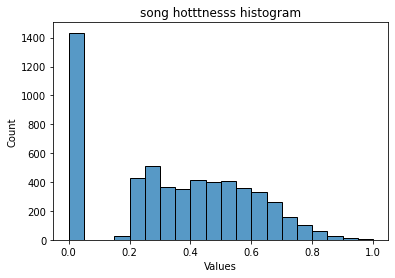

In [20]:
ax = sns.histplot(data=dfp['song_hotttnesss'],bins=20)
ax.set(title='song hotttnesss histogram', xlabel='Values');

In [21]:
sc.stop()